# Training Experiments: Image Deblurring

This notebook is for **interactive experimentation** with training configurations:
- Test different loss functions (L1, MSE, Charbonnier)
- Tune hyperparameters (learning rate, batch size, weight decay)
- Sanity check: Overfit on small dataset
- Visualize training progress in real-time
- Debug and iterate quickly

For production training runs, use `src/train.py` script.

## 1. Import Required Libraries

In [1]:
import os
import sys
import random
import importlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Add src to path
sys.path.append('.')

import src.dataset
import src.models.unet
import src.models.lightunet
import src.utils.metrics

# Reload modules to pick up changes
importlib.reload(src.dataset)
importlib.reload(src.models.unet)
importlib.reload(src.models.lightunet)
importlib.reload(src.utils.metrics)

from src.dataset import GoProDataset, get_dataloaders, get_image_pairs
from src.models.unet import SimpleUNet
from src.models.lightunet import LightweightUNet
from src.utils.metrics import calculate_psnr, PSNRMetric

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("✓ Random seeds set for reproducibility")

/Users/Gabriel/dev/konkuk/IA/project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.9.1
CUDA available: False
MPS available: True
✓ Random seeds set for reproducibility


## 2. Device Setup

Configure which device to use for training (CUDA, MPS for Apple Silicon, or CPU).

In [2]:
# Determine device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU (MPS)")
else:
    device = torch.device('cpu')
    print("Using CPU (training will be slow!)")

print(f"\nDevice: {device}")

Using Apple Silicon GPU (MPS)

Device: mps


## 3. Training Configuration

Set all hyperparameters in one place for easy experimentation.

In [3]:
class Config:
    """Training configuration - modify these for experiments"""
    
    # Data
    data_root = './data'
    patch_size = 256        # Crop size for training
    batch_size = 16          # Increased to 16 for full training (reduce to 4 if OOM)
    num_workers = 0         # Use workers for faster data loading
    
    # Model
    in_channels = 3
    out_channels = 3
    
    # Training
    num_epochs = 150        # Standard run
    learning_rate = 2e-4    # Stable LR for residual learning
    weight_decay = 1e-4     # Add slight regularization to prevent overfitting
    
    # Loss function
    loss_type = 'charbonnier'
    
    # Scheduler
    scheduler_patience = 10
    scheduler_factor = 0.5
    
    # Checkpointing
    save_dir = './experiments'
    experiment_name = 'simple_unet_full'
    
    # Early stopping
    early_stop_patience = 20
    
    # Sanity check mode
    sanity_check = False    # DISABLED: We are doing real training now!
    sanity_check_samples = 10

config = Config()

# Create save directory
os.makedirs(config.save_dir, exist_ok=True)
experiment_dir = os.path.join(config.save_dir, config.experiment_name)
os.makedirs(experiment_dir, exist_ok=True)

print("Configuration:")
for key in dir(config):
    if not key.startswith('_'):
        value = getattr(config, key)
        print(f"  {key}: {value}")
print("\n🚀 FULL TRAINING PHASE:")
print("   - Dataset: Full GoPro Train (2103 images)")
print("   - Augmentation: ENABLED (Random Crop, Flip)")
print("   - Validation: Unseen Test Set")
print("   - Goal: Val PSNR > 28 dB")

Configuration:
  batch_size: 16
  data_root: ./data
  early_stop_patience: 20
  experiment_name: simple_unet_full
  in_channels: 3
  learning_rate: 0.0002
  loss_type: charbonnier
  num_epochs: 150
  num_workers: 0
  out_channels: 3
  patch_size: 256
  sanity_check: False
  sanity_check_samples: 10
  save_dir: ./experiments
  scheduler_factor: 0.5
  scheduler_patience: 10
  weight_decay: 0.0001

🚀 FULL TRAINING PHASE:
   - Dataset: Full GoPro Train (2103 images)
   - Augmentation: ENABLED (Random Crop, Flip)
   - Validation: Unseen Test Set
   - Goal: Val PSNR > 28 dB


## 4. Loss Functions

Compare different loss functions for image deblurring:
- **L1 Loss** (MAE): Robust to outliers, produces sharper images
- **MSE Loss** (L2): Smooth results but can be blurry
- **Charbonnier Loss**: Smooth L1, combines benefits of both

In [4]:
class CharbonnierLoss(nn.Module):
    """
    Charbonnier Loss (smooth L1 loss).
    
    Loss = sqrt(||x - y||^2 + epsilon^2)
    
    Behaves like L1 for large errors, L2 for small errors.
    Often works better than pure L1 or L2 for image reconstruction.
    """
    def __init__(self, epsilon=1e-3):
        super().__init__()
        self.epsilon = epsilon
    
    def forward(self, pred, target):
        diff = pred - target
        loss = torch.sqrt(diff * diff + self.epsilon * self.epsilon)
        return loss.mean()


def get_loss_function(loss_type='l1'):
    """Get loss function by name."""
    if loss_type == 'l1':
        return nn.L1Loss()
    elif loss_type == 'mse':
        return nn.MSELoss()
    elif loss_type == 'charbonnier':
        return CharbonnierLoss()
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")


# Test the loss functions
test_pred = torch.randn(1, 3, 256, 256)
test_target = torch.randn(1, 3, 256, 256)

for loss_name in ['l1', 'mse', 'charbonnier']:
    loss_fn = get_loss_function(loss_name)
    loss_value = loss_fn(test_pred, test_target)
    print(f"{loss_name.upper():15s} loss: {loss_value.item():.6f}")

print("\n✓ Loss functions ready")

L1              loss: 1.130723
MSE             loss: 2.010360
CHARBONNIER     loss: 1.130726

✓ Loss functions ready


## 5. Load Data

Load the GoPro dataset. For sanity check mode, we'll use only a few images.

In [5]:
# Get image paths
train_blur, train_sharp = get_image_pairs(config.data_root, 'train')
test_blur, test_sharp = get_image_pairs(config.data_root, 'test')

print(f"Total training pairs: {len(train_blur)}")
print(f"Total test pairs: {len(test_blur)}")

# Sanity check mode logic
if config.sanity_check:
    train_blur = train_blur[:config.sanity_check_samples]
    train_sharp = train_sharp[:config.sanity_check_samples]
    test_blur = train_blur 
    test_sharp = train_sharp
    print(f"\n🔬 SANITY CHECK MODE: Using {len(train_blur)} training samples")

# Create datasets
# Dynamic is_train flag: True for full training, False for sanity check
train_dataset = GoProDataset(
    train_blur, 
    train_sharp, 
    patch_size=config.patch_size, 
    is_train=not config.sanity_check  # ENABLE augmentation for full training
)

val_dataset = GoProDataset(
    test_blur, 
    test_sharp, 
    patch_size=config.patch_size, 
    is_train=False  # Always False for validation (center crop)
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=not config.sanity_check,  # Shuffle for full training
    num_workers=config.num_workers,
    pin_memory=True if device.type == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"\nTrain batches per epoch: {len(train_loader)}")
print(f"Val batches per epoch: {len(val_loader)}")

if not config.sanity_check:
    print("\n✅ FULL TRAINING MODE:")
    print("   - Random Cropping: ON")
    print("   - Random Flipping: ON")
    print("   - Shuffling: ON")
else:
    print("\n⚠️ SANITY CHECK MODE: Augmentation disabled")

print("✓ Data loaded")

Total training pairs: 2103
Total test pairs: 1111

Train batches per epoch: 132
Val batches per epoch: 70

✅ FULL TRAINING MODE:
   - Random Cropping: ON
   - Random Flipping: ON
   - Shuffling: ON
✓ Data loaded


## 6. Create Model

Initialize the U-Net model and move it to the device.

In [6]:
# # Initialize model with Global Residual Learning
# model = SimpleUNet(
#     in_channels=config.in_channels,
#     out_channels=config.out_channels,
#     global_residual=True  # Enable residual learning (Output = Input + Residual)
# ).to(device)

model = LightweightUNet(
    in_channels=config.in_channels,
    out_channels=config.out_channels,
    global_residual=True  # Enable residual learning (Output = Input + Residual)
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: SimpleUNet (Global Residual: {model.global_residual})")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model on device: {next(model.parameters()).device}")

# Verify Zero Initialization
if model.global_residual:
    # Check if output layer weights are close to zero
    out_weight_mean = model.output.weight.abs().mean().item()
    print(f"Output layer weight mean: {out_weight_mean:.6f} (Should be ~0.0)")
    print("✓ Zero initialization verified - Model starts as Identity Mapping")

print("✓ Model ready")

Model: SimpleUNet (Global Residual: True)
Total parameters: 3,021,662
Trainable parameters: 3,021,662
Model on device: mps:0
Output layer weight mean: 0.000000 (Should be ~0.0)
✓ Zero initialization verified - Model starts as Identity Mapping
✓ Model ready


## 7. Setup Optimizer and Scheduler

Configure Adam optimizer with weight decay and learning rate scheduler.

In [7]:
# Loss function
criterion = get_loss_function(config.loss_type)
print(f"Loss function: {config.loss_type.upper()}")

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
print(f"Optimizer: Adam (lr={config.learning_rate}, weight_decay={config.weight_decay})")

# Learning rate scheduler - reduces LR when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',  # Maximize PSNR
    factor=config.scheduler_factor,
    patience=config.scheduler_patience,
)
print(f"Scheduler: ReduceLROnPlateau (patience={config.scheduler_patience})")
print("✓ Training setup complete")

Loss function: CHARBONNIER
Optimizer: Adam (lr=0.0002, weight_decay=0.0001)
Scheduler: ReduceLROnPlateau (patience=10)
✓ Training setup complete


## 8. Training and Validation Functions

In [8]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, disable_tqdm=False):
    """Train for one epoch."""
    model.train()
    
    running_loss = 0.0
    psnr_metric = PSNRMetric()
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", disable=disable_tqdm)
    
    for batch_idx, (blur, sharp) in enumerate(pbar):
        # Move to device
        blur = blur.to(device)
        sharp = sharp.to(device)
        
        # Forward pass
        output = model(blur)
        loss = criterion(output, sharp)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Metrics
        running_loss += loss.item()
        psnr_metric.update(output.detach(), sharp)
        
        # Update progress bar
        if not disable_tqdm:
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'psnr': f"{psnr_metric.compute():.2f}"
            })
    
    avg_loss = running_loss / len(train_loader)
    avg_psnr = psnr_metric.compute()
    
    return avg_loss, avg_psnr


def validate(model, val_loader, criterion, device, epoch, disable_tqdm=False):
    """Validate the model."""
    model.eval()
    
    running_loss = 0.0
    psnr_metric = PSNRMetric()
    
    pbar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]  ", disable=disable_tqdm)
    
    with torch.no_grad():
        for blur, sharp in pbar:
            # Move to device
            blur = blur.to(device)
            sharp = sharp.to(device)
            
            # Forward pass
            output = model(blur)
            loss = criterion(output, sharp)
            
            # Metrics
            running_loss += loss.item()
            psnr_metric.update(output, sharp)
            
            # Update progress bar
            if not disable_tqdm:
                pbar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'psnr': f"{psnr_metric.compute():.2f}"
                })
    
    avg_loss = running_loss / len(val_loader)
    avg_psnr = psnr_metric.compute()
    
    return avg_loss, avg_psnr


print("✓ Training functions defined")

✓ Training functions defined


## 9. Main Training Loop

Train the model with early stopping and checkpointing.

In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_psnr': [],
    'val_loss': [],
    'val_psnr': [],
    'lr': []
}

# Early stopping
best_psnr = 0.0
epochs_without_improvement = 0

print("Starting training...")
print("=" * 70)

for epoch in range(config.num_epochs):
    torch.mps.empty_cache()  # Clear MPS cache to prevent OOM
    # Train
    train_loss, train_psnr = train_one_epoch(
        model, train_loader, criterion, optimizer, device, epoch, disable_tqdm=False
    )
    
    # Validate
    val_loss, val_psnr = validate(
        model, val_loader, criterion, device, epoch, disable_tqdm=False
    )
    
    # Update learning rate scheduler
    scheduler.step(val_psnr)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_psnr'].append(train_psnr)
    history['val_loss'].append(val_loss)
    history['val_psnr'].append(val_psnr)
    history['lr'].append(current_lr)
    
    # Print epoch summary (every 10 epochs to avoid crashing VS Code)
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"\nEpoch {epoch+1}/{config.num_epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train PSNR: {train_psnr:.2f} dB")
        print(f"  Val Loss:   {val_loss:.4f} | Val PSNR:   {val_psnr:.2f} dB")
        print(f"  LR: {current_lr:.2e}")
    
    # Save best model
    if val_psnr > best_psnr:
        best_psnr = val_psnr
        epochs_without_improvement = 0
        
        # Save checkpoint
        checkpoint_path = os.path.join(experiment_dir, 'best_model.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_psnr': best_psnr,
            'config': vars(config)
        }, checkpoint_path)
        print(f"{epoch}/{config.num_epochs}")
        print(f"  ✓ Saved best model (PSNR: {best_psnr:.2f} dB)")
    else:
        epochs_without_improvement += 1
        print(f"  No improvement for {epochs_without_improvement} epoch(s)")
    
    # Early stopping
    if epochs_without_improvement >= config.early_stop_patience:
        print(f"\n🛑 Early stopping triggered after {epoch+1} epochs")
        print(f"Best PSNR: {best_psnr:.2f} dB")
        break
    
    print("=" * 70)

print("\n✅ Training complete!")
print(f"Best validation PSNR: {best_psnr:.2f} dB")

Starting training...


Epoch 1 [Val]  : 100%|██████████| 70/70 [00:57<00:00,  1.21it/s, loss=0.0450, psnr=25.77]




Epoch 1/150
  Train Loss: 0.0327 | Train PSNR: 26.98 dB
  Val Loss:   0.0360 | Val PSNR:   25.77 dB
  LR: 2.00e-04
0/150
  ✓ Saved best model (PSNR: 25.77 dB)


Epoch 2 [Train]:  12%|█▏        | 16/132 [01:03<07:38,  3.95s/it, loss=0.0284, psnr=27.72]

## 10. Visualize Training Progress

Plot loss and PSNR curves over epochs.

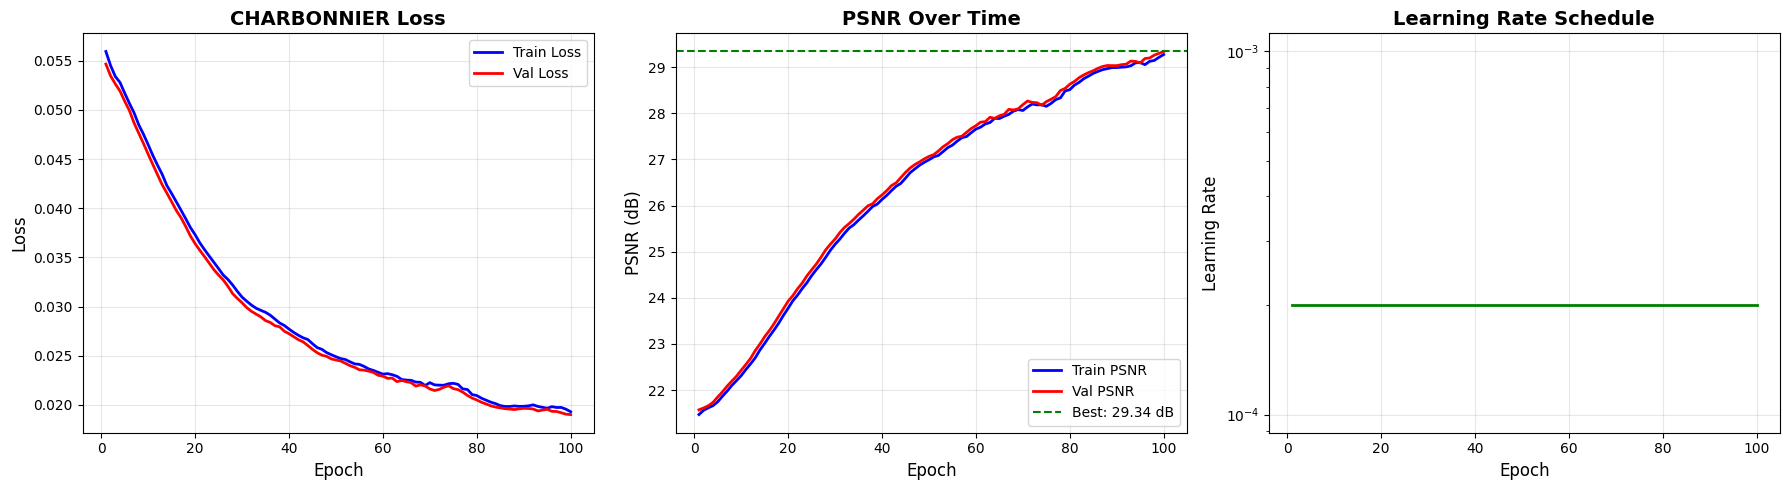

✓ Training curves saved to ./experiments/simple_unet_full/training_curves.png


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title(f'{config.loss_type.upper()} Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PSNR
axes[1].plot(epochs_range, history['train_psnr'], 'b-', label='Train PSNR', linewidth=2)
axes[1].plot(epochs_range, history['val_psnr'], 'r-', label='Val PSNR', linewidth=2)
axes[1].axhline(y=best_psnr, color='g', linestyle='--', label=f'Best: {best_psnr:.2f} dB')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('PSNR (dB)', fontsize=12)
axes[1].set_title('PSNR Over Time', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate
axes[2].plot(epochs_range, history['lr'], 'g-', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(experiment_dir, 'training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved to {experiment_dir}/training_curves.png")

## 11. Visualize Sample Predictions

Load the best model and visualize predictions on validation set.

Loaded best model from epoch 100
Best PSNR: 29.34 dB


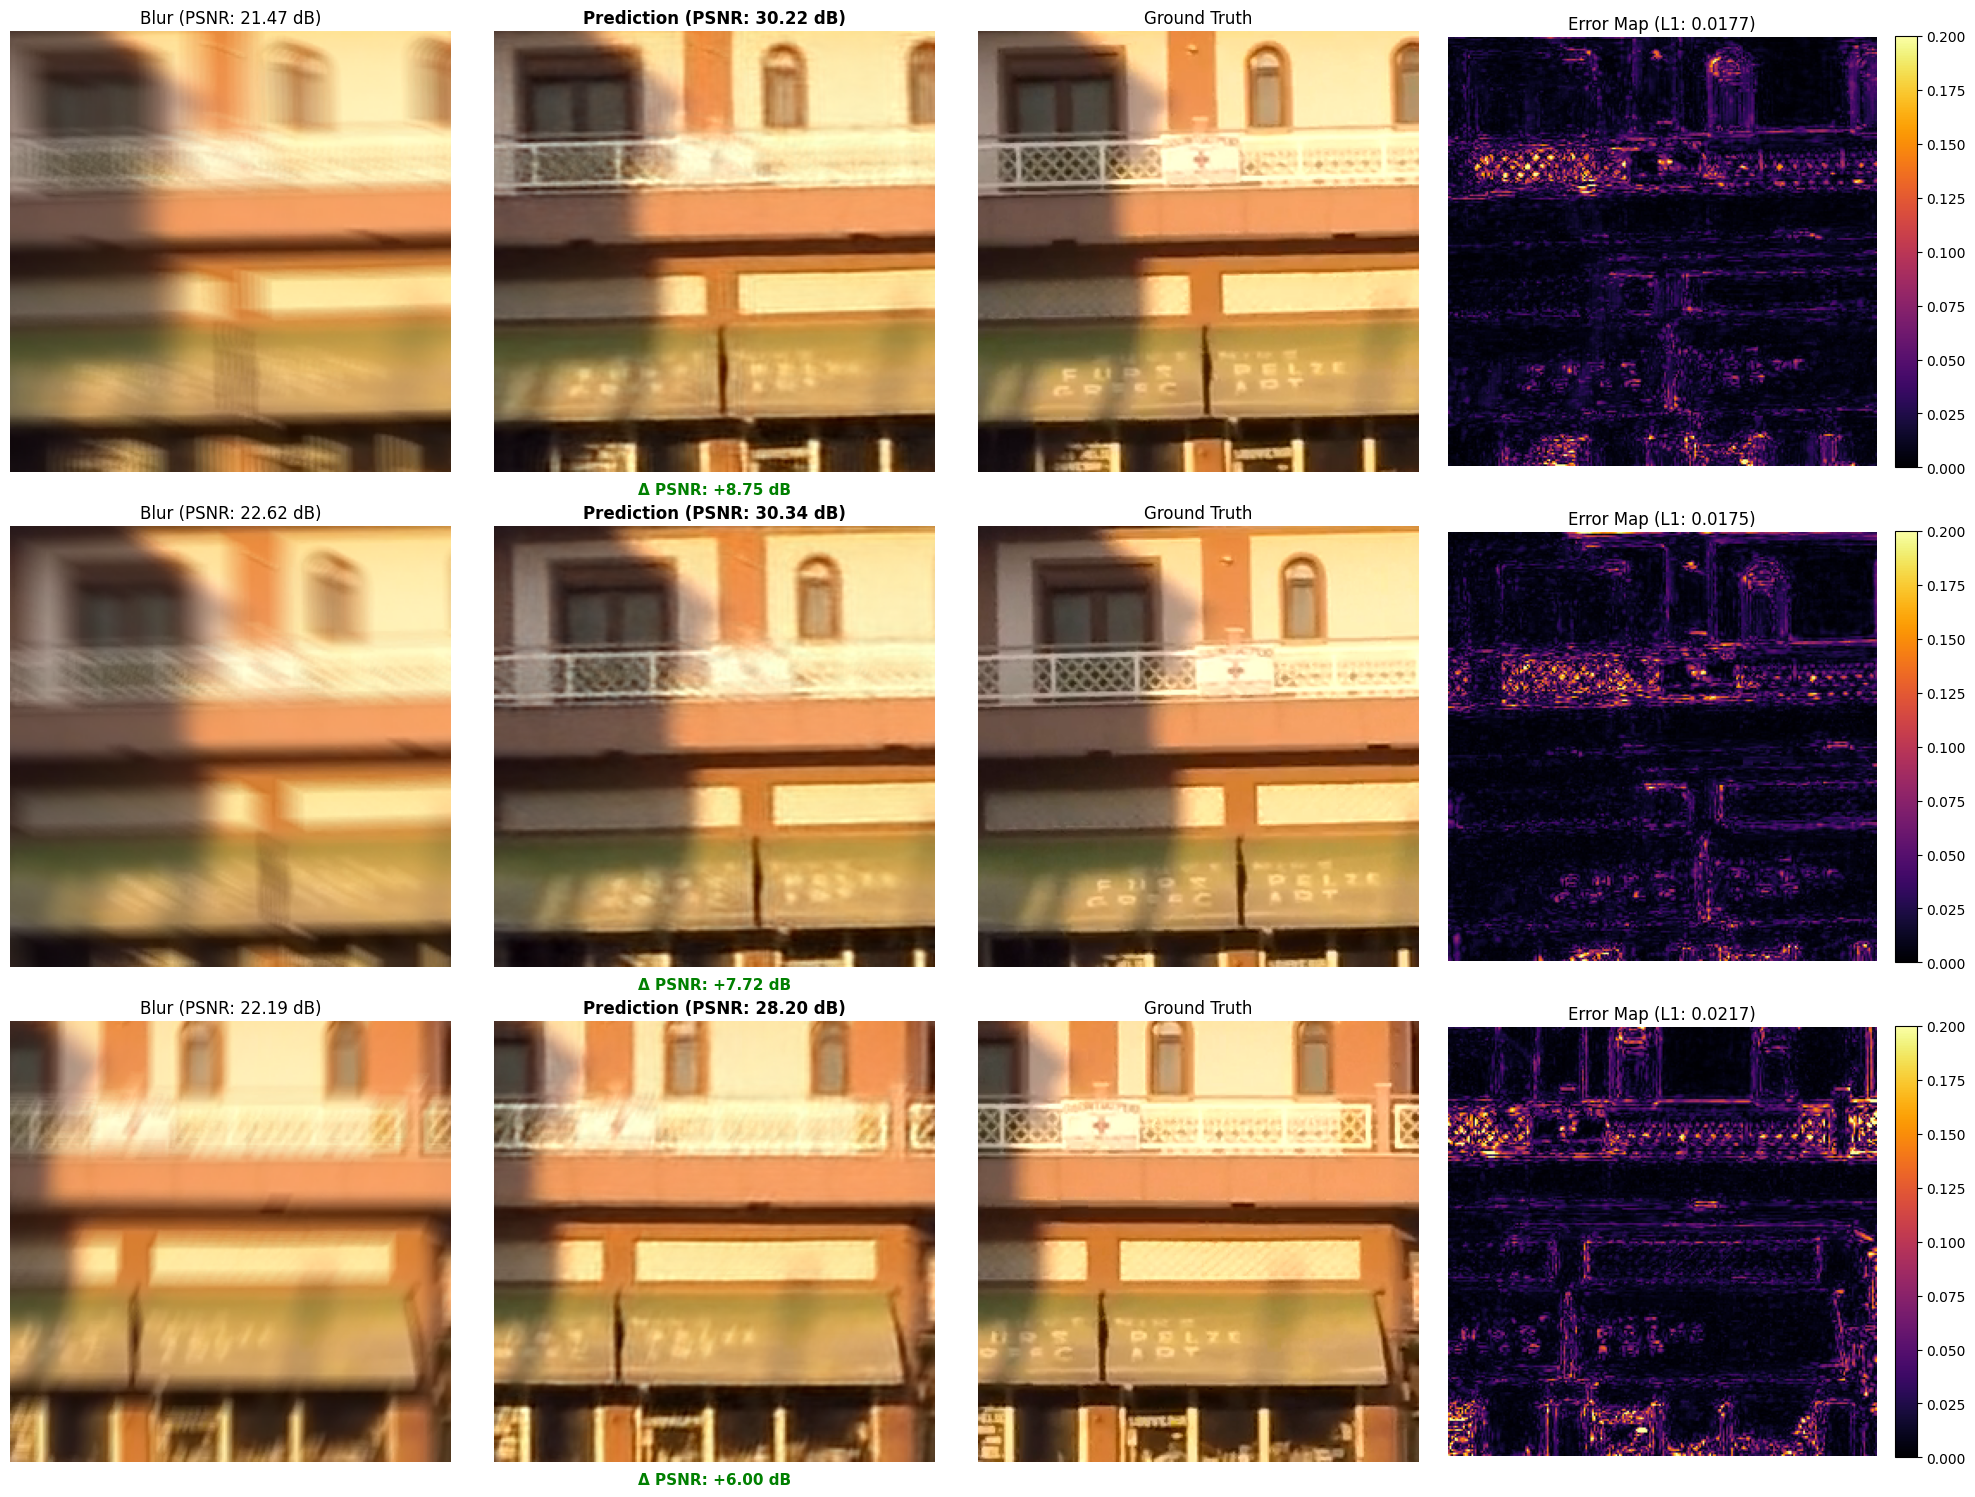

✓ Sample predictions saved to ./experiments/simple_unet_full/sample_predictions.png


In [ ]:
# Load best model
checkpoint = torch.load(os.path.join(experiment_dir, 'best_model.pth'), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best PSNR: {checkpoint['best_psnr']:.2f} dB")

# Get a few validation samples
n_samples = 3
sample_indices = random.sample(range(len(val_dataset)), min(n_samples, len(val_dataset)))

fig, axes = plt.subplots(n_samples, 4, figsize=(20, 5*n_samples))
if n_samples == 1:
    axes = axes.reshape(1, -1)

with torch.no_grad():
    for i, idx in enumerate(sample_indices):
        blur, sharp = val_dataset[idx]
        
        # Add batch dimension and move to device
        blur_input = blur.unsqueeze(0).to(device)
        
        # Predict
        pred = model(blur_input).cpu().squeeze(0)
        
        # Calculate PSNR
        psnr_blur = calculate_psnr(blur.unsqueeze(0), sharp.unsqueeze(0)).item()
        psnr_pred = calculate_psnr(pred.unsqueeze(0), sharp.unsqueeze(0)).item()
        
        # Convert to numpy for visualization
        blur_np = blur.permute(1, 2, 0).numpy()
        sharp_np = sharp.permute(1, 2, 0).numpy()
        pred_np = pred.permute(1, 2, 0).numpy()
        
        # Clip to [0, 1] for visualization
        pred_np = np.clip(pred_np, 0, 1)
        
        # Calculate Error Map
        error_map = np.abs(pred_np - sharp_np).mean(axis=2) # Average over channels
        
        # Plot
        axes[i, 0].imshow(blur_np)
        axes[i, 0].set_title(f'Blur (PSNR: {psnr_blur:.2f} dB)', fontsize=12)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(pred_np)
        axes[i, 1].set_title(f'Prediction (PSNR: {psnr_pred:.2f} dB)', fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(sharp_np)
        axes[i, 2].set_title(f'Ground Truth', fontsize=12)
        axes[i, 2].axis('off')
        
        # Error Map
        im = axes[i, 3].imshow(error_map, cmap='inferno', vmin=0, vmax=0.2)
        axes[i, 3].set_title(f'Error Map (L1: {error_map.mean():.4f})', fontsize=12)
        axes[i, 3].axis('off')
        plt.colorbar(im, ax=axes[i, 3], fraction=0.046, pad=0.04)
        
        improvement = psnr_pred - psnr_blur
        color = 'green' if improvement > 0 else 'red'
        axes[i, 1].text(0.5, -0.05, f'Δ PSNR: {improvement:+.2f} dB', 
                       transform=axes[i, 1].transAxes,
                       ha='center', fontsize=11, color=color, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(experiment_dir, 'sample_predictions.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Sample predictions saved to {experiment_dir}/sample_predictions.png")

---

## Summary & Next Steps

### What We Built:
✅ Complete training pipeline with loss functions, optimizer, and scheduler  
✅ Training loop with gradient clipping and PSNR tracking  
✅ Validation loop with early stopping  
✅ Model checkpointing (saves best model)  
✅ Visualization of training curves and predictions  

### Quick Start Guide:

**1. Sanity Check (Overfit on small dataset):**
```python
config.sanity_check = True
config.num_epochs = 100
config.batch_size = 2
# Re-run cells 6-11 to train on 10 images
```

**2. Quick Experiment (Test configurations):**
```python
config.sanity_check = False
config.num_epochs = 20
config.batch_size = 4
config.loss_type = 'charbonnier'  # Try different losses
```

**3. Full Training:**
```python
config.sanity_check = False
config.num_epochs = 100
config.batch_size = 8  # Increase if you have GPU memory
```

### Experiment Ideas:
- Compare loss functions: `'l1'`, `'mse'`, `'charbonnier'`
- Try different learning rates: `1e-3`, `1e-4`, `1e-5`
- Adjust weight decay: `0`, `1e-5`, `1e-4`, `1e-3`
- Change patch size: `128`, `256`, `384`

### Next Steps:
1. **Run sanity check** - Verify model can overfit on 10 images
2. **Tune hyperparameters** - Find best configuration
3. **Create `src/train.py`** - Production training script
4. **Build Residual U-Net** - Improve model with residual connections

---

## Troubleshooting: Why Was Training Stuck at 19 dB?

### Root Cause: Data Augmentation During Sanity Check ❌

**The Problem:**
- With `is_train=True`, dataset applies **random crops** to training images
- Each epoch, the model saw **different 256x256 patches** from the same 10 images
- Model never truly "memorized" the data because patches kept changing
- Like trying to memorize a book while someone keeps shuffling the pages!

**The Fix:**
- Set `is_train=False` for training dataset during sanity check
- Now uses **center crop** - exact same patches every epoch
- Set `shuffle=False` - same order every epoch
- Model can now properly overfit and memorize the exact patches

### Other Optimizations for Sanity Check:

1. **Removed Weight Decay**: `weight_decay=0`
   - No regularization penalty - we WANT overfitting for sanity check

2. **Increased Learning Rate**: `lr=1e-3` (from 5e-4)
   - Faster convergence to zero loss

3. **Increased Batch Size**: `batch_size=4` (from 2)
   - More stable gradient estimates
   - Better weight updates

4. **Longer Patience**: `early_stop_patience=20` (from 10)
   - Give model more time to fully overfit

### Expected Results NOW:
- **Epoch 10-20**: PSNR 25-30 dB
- **Epoch 30-40**: PSNR 32-36 dB  
- **Epoch 50+**: PSNR 38-45 dB (near perfect reconstruction)
- **Training loss**: Should approach ~0.01 or lower

### Key Lesson:
Always **disable augmentation for sanity checks**! You need the model to see the exact same data to verify it can memorize and overfit properly.

---

## Debug: Check Model Output Range

Let's investigate what values the model is producing.

In [ ]:
# Load best model and check output range
checkpoint = torch.load(os.path.join(experiment_dir, 'best_model.pth'), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Get a training sample
blur, sharp = train_dataset[0]
blur_input = blur.unsqueeze(0).to(device)

with torch.no_grad():
    pred = model(blur_input).cpu().squeeze(0)

print("=== Model Output Analysis ===")
print(f"Input (blur) range: [{blur.min():.4f}, {blur.max():.4f}]")
print(f"Target (sharp) range: [{sharp.min():.4f}, {sharp.max():.4f}]")
print(f"Prediction range: [{pred.min():.4f}, {pred.max():.4f}]")
print(f"\nPrediction stats:")
print(f"  Mean: {pred.mean():.4f}")
print(f"  Std: {pred.std():.4f}")
print(f"  Values < 0: {(pred < 0).sum().item()}")
print(f"  Values > 1: {(pred > 1).sum().item()}")
print(f"  Total pixels: {pred.numel()}")

# Calculate PSNR with and without clipping
psnr_no_clip = calculate_psnr(pred.unsqueeze(0), sharp.unsqueeze(0)).item()
pred_clipped = torch.clamp(pred, 0, 1)
psnr_clipped = calculate_psnr(pred_clipped.unsqueeze(0), sharp.unsqueeze(0)).item()

print(f"\nPSNR without clipping: {psnr_no_clip:.2f} dB")
print(f"PSNR with clipping [0,1]: {psnr_clipped:.2f} dB")
print(f"Difference: {psnr_clipped - psnr_no_clip:+.2f} dB")

=== Model Output Analysis ===
Input (blur) range: [0.0039, 1.0000]
Target (sharp) range: [0.0000, 1.0000]
Prediction range: [-0.1549, 1.1408]

Prediction stats:
  Mean: 0.4999
  Std: 0.2855
  Values < 0: 736
  Values > 1: 5584
  Total pixels: 196608

PSNR without clipping: 30.34 dB
PSNR with clipping [0,1]: 30.47 dB
Difference: +0.13 dB


---

## Debug: Check if Model is Learning

Let's verify weights are actually updating during training.

In [ ]:
# Check if any weights are frozen
frozen_params = []
for name, param in model.named_parameters():
    if not param.requires_grad:
        frozen_params.append(name)

if frozen_params:
    print(f"⚠️  Found {len(frozen_params)} frozen parameters:")
    for name in frozen_params[:10]:
        print(f"  - {name}")
else:
    print("✓ All parameters are trainable")

# Check weight statistics before/after one training step
print("\n=== Weight Update Test ===")
blur_batch, sharp_batch = next(iter(train_loader))
blur_batch = blur_batch.to(device)
sharp_batch = sharp_batch.to(device)

# Get initial weight
first_conv_weight = model.encoder1.conv1.conv.weight.clone()

# One training step
model.train()
output = model(blur_batch)
loss = criterion(output, sharp_batch)
optimizer.zero_grad()
loss.backward()
optimizer.step()

# Check if weight changed
weight_diff = (model.encoder1.conv1.conv.weight - first_conv_weight).abs().mean().item()
print(f"First conv layer weight change: {weight_diff:.6f}")
print(f"Loss value: {loss.item():.6f}")

if weight_diff > 0:
    print("✓ Weights are updating!")
else:
    print("❌ Weights are NOT updating - something is wrong!")

✓ All parameters are trainable

=== Weight Update Test ===


AttributeError: 'LightweightUNet' object has no attribute 'encoder1'